# Основные этапы


## Данные
- Скидывать папку вместо архива - не очень хорошая идея
- Гугл драйв не может выкачать на ПК такую папку явно. Возможна проблема на стороне самого драйва. И другие замарочки с данными


## Идеи
- "10К ... изображений" - изображений достаточно для использования fine-tuning'a какой-нибудь нейронной сети для решения задачи
- "10К ПАР изображений" - это несколько меняет всю концепцию: в парах мало пересечений между собой, соответсвенно дообучить модель будет проблематично; каждая пара представляет некоторый отдельный класс объектов, поэтому нужно больше данных для каждой пары, чтобы суметь отличить данный класс; нет доступа к валидационным данным, соответсвенно могут появиться объекты из классов, на которых не обучалась модель
- не использовать сети при построениии модели


## Решение
- Общие замечания. В описании данных явно не сказано, какое отношение между объектами в каждой паре. В худшем случае может быть смесь, состоящая из пар объектов с высоким значением схожести и низким. Отсюда получается задача кластеризации например на 2 класса: с высокой и низкой схожестью. Для отличия между такими классами нужно выставить некоторый порог по метрике схожести двух изображений.
- Метрика. У меня не было опыта выполнения и знаний для решения данной задачи, поэтому немного погуглив я нашел 2 метрики, которые помогают ответить на вопрос о схожести/идентичности двух изображений.
    - SSIM - https://ru.wikipedia.org/wiki/SSIM. Есть готовая реализация: skimage.metrics.structural_similarity
    - PSNR - https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio. Есть готовая реализация: skimage.metrics.peak_signal_noise_ratio
- Данные. Есть сильное предположение, что в первой части данных в парах изображений содержатся картинки одного и того же объекта с применением crop'a. Изображения разного веса и размера, соответсвенно нужно будет привести к одинаковому размеру.
- Модель. 
    - Напрямую сделать расчет метрик с подготовленными изображениями
    - В парах содержатся части изображений => Сделать собственный crop картинки на 4 части и еще одну для центральной. На полученных частях посчитать метрики
    - Наивный вариант - посчитать значение метрики схожести. Это и будет ответом
    - Взять некоторое количество пар с метриками из исходных данных - это будет класс 1, добавить перекрестное сравнение изображений из разных пар - это будет класс 0. Обучить на этих данных логистическую регрессию и выдавать вероятность принадлежности к классу, которые будут говорить о схожести изображений. Другими словами - аггрегировать информацию наивного метода.
- Результат. Модель с использованием логистической регрессии оказалась лучшей


## PS
- Очень интересно получить обратную связь по моему решению и по тому какие идеи здесь можно использовать
- Была еще идея, связанная с сегментацией: выделение содержимого картинки, подгон сдвигов и растяжений получится более качественный с учетом площади. Не получилось проверить

    
## Bugfix
- Представленные картинки имеют разные цветовые модели, что приводит к разной размерности на выходе функции imread. Добавление в данную функцию параметра plugin='pil' должно решить данную проблему: 
    - RGB (https://en.wikipedia.org/wiki/RGB_color_model)
    - RGBA (https://en.wikipedia.org/wiki/RGBA_color_model)
- Использование плагина не решило проблему, поэтому лучше действовать наверняка. Использование конвертации, которая будет преобразовывать в "RGB". np.array(Image.open(image_path).convert('RGB')). К сожалению у меня нет доступа к полному датасету, поэтому отловить возможные проблемы сложно
  
  
## Update
- Добавлена функция для вычисления метрик accuracy, precision и recall с изменяемым порогом для разделения классов


In [ ]:
import os
import pickle
import random 
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score


RESCALE_SIZE = 224
PATH_DATA = r"D:\data"
warnings.simplefilter("ignore")

## Обработка изображений
- необходимо включить в файл, если интересен запуск из командной строки
- нужно поменять гиперпараметр PATH_DATA на свой

In [16]:
# Сборка картинок в директории
def read_files_in_directory(path=PATH_DATA):
    first_images = []
    second_images = []
    for name in os.listdir(path=path):
        if name.find('_1.jpg')>0:
            first_images.append(path+"\\"+name)
        elif name.find('_2.jpg')>0:
            second_images.append(path+"\\"+name)
    return first_images, second_images
        
# Проверка вхождений пар
def clear_data(list_1, list_2):
    bad_names = []
    for name in list_1:
        if name.replace("_1", "_2") not in list_2:
            bad_names.append(list_1.index(name))
    for name in bad_names:
        del list_1[name]
    
    bad_names = []
    for name in list_2:
        if name.replace("_2", "_1") not in list_1:
            bad_names.append(list_2.index(name))
    for name in bad_names:
        del list_2[name]

    assert len(list_2) == len(list_1)
    return list_1, list_2

# Разбивание изображение на части
def crop_image(image):
    crop = [
        image[0:RESCALE_SIZE//2, 0:RESCALE_SIZE//2],
        image[0:RESCALE_SIZE//2, RESCALE_SIZE//2:RESCALE_SIZE],
        image[RESCALE_SIZE//2:RESCALE_SIZE, 0:RESCALE_SIZE//2],
        image[RESCALE_SIZE//2:RESCALE_SIZE, RESCALE_SIZE//2:RESCALE_SIZE],
        image[RESCALE_SIZE//4:3*RESCALE_SIZE//4, RESCALE_SIZE//4:3*RESCALE_SIZE//4]
    ]
    return crop

# Приведение картинки к стандартному виду
def resize_image(image_path):
    image = np.array(Image.open(image_path).convert('RGB'))
    return resize(image, (RESCALE_SIZE, RESCALE_SIZE), order=0)

## Первое решение (наивный подход)
- делаем обработку изображения
- считаем метрику для разных кропов и целых изображений
- выводим оценку с учетом поправки на интервал выходных значений для SSIM

In [17]:
# Использование наивного расчета метрик
def simple_metrics(im1_path, im2_path):
    # Приводим к одинаковому размеру
    image_1 = resize_image(im1_path)
    image_2 = resize_image(im2_path)
    assert image_1.shape == image_2.shape, f"Images has not equal size: {image_1.shape} and {image_2.shape}!"
    
    # Разбиваем изображение на части для борьбы со сдвигами
    crop_im1 = crop_image(image_1)
    crop_im2 = crop_image(image_2)
    
    # Считаем метрику для разбиений
    answer_ssim = [structural_similarity(image_1, image_2, multichannel=True)]
    for crop1 in crop_im1:
        for crop2 in crop_im2:
            answer_ssim.append(structural_similarity(crop1, crop2, multichannel=True))
    
    # Метрика отображает в интервал [-1, 1]. Преобразование дает интервал [0, 1]
    # Выбираем max из полученных значений
    return (max(answer_ssim)+1)/2

# Проверка работоспособности функции
# im1 = r"D:\data\1220000150683_1.jpg"
im1 = r"D:\data\7709649318240_1.jpg"
im2 = r"D:\data\1220000150683_2.jpg"
# im2 = r"D:\data\26102895184_2.jpg"
im3 = r"D:\data\8690506090043_1.jpg"
simple_metrics(im1_path=im1, im2_path=im3)

C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


0.7639380083614036

## Второе решение (обучение более сложной модели)
- разбиение на тестовую и валидационную выборки
- создание искуственного класса 0. (Ставится задача бинарной классификации)
- считаем метрики сходства для каждой пары изображений
- обучаем логистическую регрессию и сохраняем ее веса
- ошибка при расчете метрики на валидационной выборке говорит о том, что идея вполне жизнеспособна

In [18]:
# Попытка собрать некоторое количество данных для обучения логистической регрессии
# Первый класс - похожие изображения, второй класс - разные. Вероятность определяет принадлежность к первому классу
first_images, second_images = read_files_in_directory(path=PATH_DATA)
first_images, second_images = clear_data(first_images, second_images)
print(len(first_images), len(second_images))

# Сильное предположение 1: изначальные данные содержат пары картинок, у которых высокая степень сходства
# Сильное предположение 2: если брать в пару к первому изображению второе некоторым образом, то будет малое сходство

# Создадим валидационную выборку из изначальных пар. Это будет класс 1
all_paths = list(zip(first_images, second_images))
paths_train, paths_valid = train_test_split(all_paths, shuffle=True, test_size=0.2)
print(len(paths_train), len(paths_valid))

y_train = np.ones([len(paths_train)])
y_valid = np.ones([len(paths_valid)])

# Добавляем пары, которые будут отвечать за второй класс
for i in range(0, len(paths_train)-20):
    paths_train.append((paths_train[i][0], paths_train[random.randint(3+i,15+i)][1]))

# Нужно посчитать метрики качества для каждой пары в выборках
y_train = np.concatenate((y_train, np.zeros([len(paths_train)-y_train.shape[0]])))

def preapare_data(paths):
    X = np.zeros([len(paths), 26])
    for i in tqdm(range(len(paths))):
        image_crop_1 = crop_image(resize_image(paths[i][0]))
        image_crop_2 = crop_image(resize_image(paths[i][1]))

        # Считаем метрику для разбиений
        if resize_image(paths[i][0]).shape != resize_image(paths[i][1]).shape:
            print(resize_image(paths[i][0]).shape, paths[i][0])
            print(resize_image(paths[i][1]).shape, paths[i][1])
        answer_ssim = [structural_similarity(resize_image(paths[i][0]), 
                                         resize_image(paths[i][1]), multichannel=True)]
        for crop1 in image_crop_1:
            for crop2 in image_crop_2:
                answer_ssim.append(structural_similarity(crop1, crop2, multichannel=True))
    
        X[i] = answer_ssim
    return X

X_train = preapare_data(paths_train)
X_valid = preapare_data(paths_valid)

787 787
629 158


  5%|████▎                                                                           | 67/1238 [00:47<34:20,  1.76s/it]C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|████████████████████████████████████████████████████████████████████████████████| 158/158 [01:38<00:00,  1.60it/s]


In [19]:
parameters = {
    'penalty': ('elasticnet', ),
    'C': (100, 10, 1, 0.1, 0.01, 0.001),
    'class_weight': ('balanced', None),
    'solver': ('saga',),
    'n_jobs': (-1,),
    'l1_ratio': (0.1, 0.3, 0.5, 0.9),
    'random_state': (234,)
}

lr_clf =  LogisticRegression()
gs_lr_clf = GridSearchCV(lr_clf, parameters, cv=3, scoring='roc_auc')
gs_lr_clf.fit(X_train, y_train)
print('LogisticRegression - best estimator: ', gs_lr_clf.best_estimator_)
print('LogisticRegression - best score: ', gs_lr_clf.best_score_)
print("LogisticRegression - best predict: ", roc_auc_score(y_valid, gs_lr_clf.predict(X_valid)))

# Сохранение модели
filename =  PATH_DATA + "\\" + 'finalized_model.sav'
pickle.dump(gs_lr_clf.best_estimator_, open(filename, 'wb'))

# Интересное сообщение об ошибке. Валидационная выборка полностью состоит из объектов первого класса. Причем
# выбирались данные рандомно из предложенных данных, что подтверждает предположение о классах.
# ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

LogisticRegression - best estimator:  LogisticRegression(C=10, l1_ratio=0.5, n_jobs=-1, penalty='elasticnet',
                   random_state=234, solver='saga')
LogisticRegression - best score:  0.9177547915167826


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

## Второе решение (функция для продвинутой оценки)
- делаем обработку изображения
- считаем метрику SSIM для разных кропов и целых изображений
- загружем обученную модель и делам предсказание

In [20]:
def advanced_model(im1_path, im2_path):
    # Приводим к одинаковому размеру
    image_1 = resize_image(im1_path)
    image_2 = resize_image(im2_path)
    assert image_1.shape == image_2.shape, f"Images has not equal size: {image_1.shape} and {image_2.shape}!"
    
    # Разбиваем изображение на части для борьбы со сдвигами
    crop_im1 = crop_image(image_1)
    crop_im2 = crop_image(image_2)
    
    # Считаем метрику для разбиений
    answer_ssim = [structural_similarity(image_1, image_2, multichannel=True)]
    for crop1 in crop_im1:
        for crop2 in crop_im2:
            answer_ssim.append(structural_similarity(crop1, crop2, multichannel=True))
            
    filename = PATH_DATA + "\\" + 'finalized_model.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    answer = loaded_model.predict_proba([answer_ssim])[0][1]
    
    return answer


# Проверка работоспособности функции
im1 = r"D:\data\1220000150683_1.jpg"
im2 = r"D:\data\1220000150683_2.jpg"
# im2 = r"D:\data\9785995135616_2.jpg"
advanced_model(im1_path=im1, im2_path=im2)

0.9897571981898228

## Вычисление метрик для оценки качества предложенных моделей
- принимает на вход одно из решений
- расчитываеются метрики accuracy, precision, recall в зависимости от порога

In [27]:
# Function for count metrics for preparing model
def count_metrics_for_model(path_to_images=PATH_DATA, add_sec_class=True, threshold=0.5, 
                            func_to_eval=advanced_model):
    """
    path_to_images: str (directory with images)
    add_sec_class: bool (if need add second class)
    threshold: float (separation threshold for classes)
    func_to_eval: advanced_model or simple_metrics (model for estimation)
    """ 
    # Preapare data for count metrics
    # Hypothesis 1: the initial data contains pairs of pictures that have a high degree of similarity
    # Hypothesis 2: if you pair the first image with the second in some way, then there will be little resemblance
    
    ## Download images from path
    first_images, second_images = read_files_in_directory(path=path_to_images)
    first_images, second_images = clear_data(first_images, second_images)
    
    ## This step prepare separation on 0- and 1- class
    all_paths = list(zip(first_images, second_images))
    y_all = np.ones([len(all_paths)])
    
    ## Adding second class
    if add_sec_class:
        for i in range(0, len(paths_train)-20):
            all_paths.append((all_paths[i][0], all_paths[random.randint(3+i,15+i)][1]))
        y_all = np.concatenate((y_all, np.zeros([len(all_paths)-y_all.shape[0]])))
        
    y_pred = np.zeros([len(all_paths)])
    for image, index in tqdm(zip(all_paths, range(len(y_pred)))):
        y_pred[index] = 1 if func_to_eval(im1_path=image[0], im2_path=image[1]) >= threshold else 0
        
    return (accuracy_score(y_all, y_pred), precision_score(y_all, y_pred), recall_score(y_all, y_pred))


count_metrics_for_model(threshold=0.9)

2005it [08:26,  3.96it/s]


(0.8129675810473815, 0.9364406779661016, 0.5616264294790343)

In [28]:
count_metrics_for_model(func_to_eval=simple_metrics, threshold=0.9)

2005it [08:46,  3.81it/s]


(0.6374064837905237, 0.8409090909090909, 0.0940279542566709)

## Поиск порога
- графики зависимости метрик от порога для предложенных решений

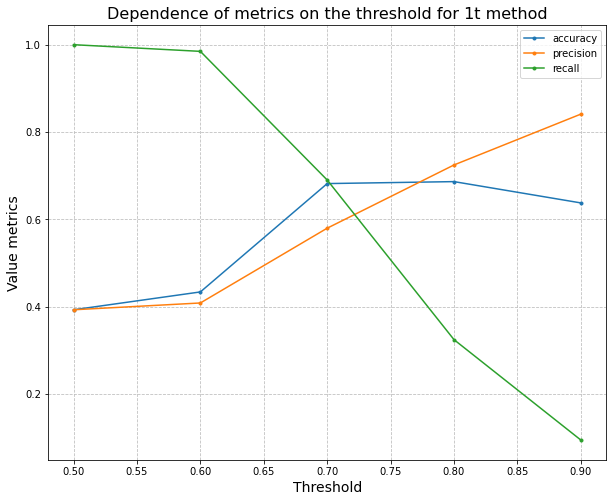

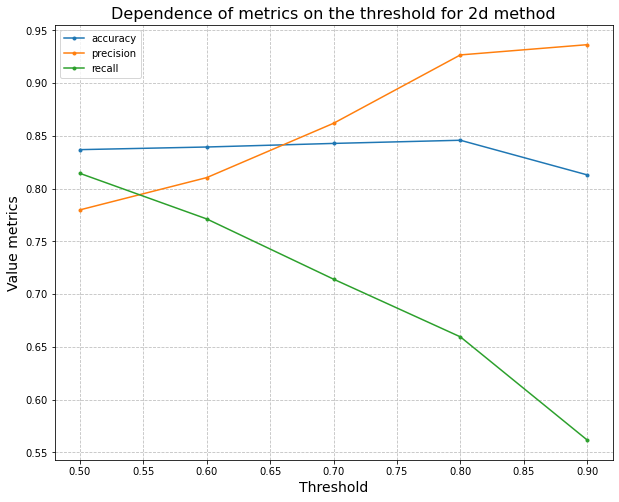

In [32]:
thr = [0.5, 0.6, 0.7, 0.8, 0.9]


sim_acc = [0.3925, 0.4334, 0.6817, 0.6862, 0.6374]
sim_pre = [0.3925, 0.4081, 0.5795, 0.7244, 0.8409]
sim_rec = [1.0, 0.9847, 0.6899, 0.3240, 0.0940]

plt.figure(figsize = (10, 8))
plt.grid(True, linestyle='--', color='0.75')
plt.xlabel('Threshold', size = '14')
plt.ylabel('Value metrics', size = '14')
plt.title('Dependence of metrics on the threshold for 1t method', size = '16')
plt.plot(thr, sim_acc, '.-', label='accuracy')
plt.plot(thr, sim_pre, '.-', label='precision')
plt.plot(thr, sim_rec, '.-', label='recall')
plt.legend()


adv_acc = [0.8369, 0.8394, 0.8428, 0.8458, 0.81296]
adv_pre = [0.7798, 0.8104, 0.8619, 0.9267, 0.9364]
adv_rec = [0.8144, 0.7712, 0.7141, 0.6594, 0.5616]

plt.figure(figsize = (10, 8))
plt.grid(True, linestyle='--', color='0.75')
plt.xlabel('Threshold', size = '14')
plt.ylabel('Value metrics', size = '14')
plt.title('Dependence of metrics on the threshold for 2d method', size = '16')
plt.plot(thr, adv_acc, '.-', label='accuracy')
plt.plot(thr, adv_pre, '.-', label='precision')
plt.plot(thr, adv_rec, '.-', label='recall')
plt.legend()

## Вывод
- Оценка моделей идет по 3 метрикам, поэтому наилучший случай - все 3 имеют высокое значение
- При пороге в интервале [0.65, 0.75] первое решение показывает сносный результат - 0.6 в среднем для всех метрик
- При пороге в интервале [0.5, 0.65] второе решение показывает хороший результат - 0.8 в среднем для всех метрик
- Модель на основе логистической регрессии показывает лушие результаты